In this project we will analyze several logs from Yandex.Afisha servers with information about users activity - visits and orders they made from June 2017 through May 2018 and marketing expenses statistics for this period. The main goal of this analysis is to help optimize marketing expenses.
The questions we need to answer are: 

* How people use the product
* When they start to buy
* How much money each customer brings
* When they pay off

In [4]:
# Import all libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [5]:
# Load the data
try:
  visits = pd.read_csv('/content/drive/MyDrive/csv_fies/visits_log_us.csv', parse_dates=['Start Ts', 'End Ts'], dtype={'Device': 'category'})
  orders = pd.read_csv('/content/drive/MyDrive/csv_fies/orders_log_us.csv', parse_dates=['Buy Ts'])
  costs = pd.read_csv('/content/drive/MyDrive/csv_fies/costs_us.csv', parse_dates=['dt'])
except:
  visits = pd.read_csv('/datasets/visits_log_us.csv', parse_dates=['Start Ts', 'End Ts'], dtype={'Device': 'category'})
  orders = pd.read_csv('/datasets/orders_log_us.csv', parse_dates=['Buy Ts'])
  costs = pd.read_csv('/datasets/costs_us.csv', parse_dates=['dt'])  

Initially the memory usage of `costs` table was 206.2 KB. After making manipulations while reading the files, such as parsing dates and encoding data type as category we managed to save ourselves some memory.

In [6]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


# PREPROCESSING

We need to explore our data and see if we have any missing values, inaproproate data types or duplicates. To do so, we can save all our datasets in a list and iterate over it to save some time.

In [7]:
# Store all datasets in a list
datasets = [visits, orders, costs]

In [8]:
# Customized function for data exploring
def explore(data):
  print('*_*' * 20)
  print()
  print('Dataframe Info:')
  data.info()
  print()
  print('Missing values:')
  print(data.isnull().sum())
  print()
  print('Checking duplicates:')
  print(data.duplicated().sum())
  print()
  print('Dataframe shape:')
  print(data.shape)
  print()

Lets' apply the function.

In [9]:
for i in datasets:
  explore(i)

*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB

Missing values:
Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

Checking duplicates:
0

Dataframe shape:
(359400, 5)

*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---

Lets' describe our columns more detailed:

The `visits` table (server logs with data on website visits):
* `Uid` — user's unique identifier
* `Device` — user's device
* `Start Ts` — session start date and time
* `End Ts` — session end date and time
* `Source Id` — identifier of the ad source the user came from

All dates in this table are in **YYYY-MM-DD** format.

The `orders` table (data on orders):
* `Uid` — unique identifier of the user making an order
* `Buy Ts` — order date and time
* `Revenue` — Yandex.Afisha's revenue from the order

The `costs` table (data on marketing expenses):
* `source_id` — ad source identifier
* `dt` — date
* `costs` — expenses on this ad source on this day




We have no missing values or duplicates, the data types that needed to be changed were processed while reading the files. Although, the names of some columns are written with spaces and in uppercase register. We will change that, usihg `str.replace` and `str.lower` methods. That will be easy to fix in a loop.

In [10]:
for i in datasets:
  i.columns = i.columns.str.replace(' ', '_').str.lower()

All of issues with our datasets concerning preprocessing have been taken care of and we can move on to the next parts of our project.

# MAKING REPORTS

## *First component we need to explore is our product*

---



**How many people use it every day, week, and month?**

The right way to answer this question will be calculating metrics, such as DAU aka daily active users, WAU - weekly active users and MAU - monthly active users. This is a basic metric and it can be calculated by grouping our data by date/week/month and counting the ammount of unique user ids for that period of time.

In [11]:
# Extract the month, week and date out of our timestamp
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27


In [12]:
dau = visits.groupby('session_date', as_index=False).agg({'uid': 'nunique'})
wau = visits.groupby('session_week', as_index=False).agg({'uid': 'nunique'})
mau = visits.groupby('session_month', as_index=False).agg({'uid': 'nunique'})
wau.head()

,session_week,uid
0,2017-06-01,4082
1,2017-06-08,3311
2,2017-06-15,2844
3,2017-06-22,3079
4,2017-06-29,3055


We can plot our metrics to see the dynamics over time using a lineplot.

In [13]:
fig = px.line(dau, x = 'session_date', y = 'uid', title = 'Daily Active Users')
fig.add_hline(y = dau['uid'].median(), line_dash = 'dash', line_color = 'green', annotation_text = 'median DAU', annotation_position = 'top left')
fig.update_layout(yaxis_title='Active users', xaxis_title = 'Dates')
fig.show()

In [14]:
print('Overall average daily active users is:{:.0f}'.format(dau['uid'].median()))

Overall average daily active users is:921


On the graph we can *3 major periods*: first from **June 2017 to September 25-th 2017** where the daily users activity was below the average, with a peak in **July 17-th**, second we have a period of time from end of **September 2017 untill end of March 2018** - thats where all the high above average activity is concentrated, and third by the **31-st of March 2018** there is a decrease. The highest peak of activity was on **November 24-th 2017** - usually it is time for black fridays. It was bigger than the average by almost 3 times.

In [15]:
fig = px.line(wau, x = 'session_week', y = 'uid', title = 'Weekly Active Users')
fig.add_hline(y = wau['uid'].median(), line_dash = 'dash', line_color = 'green', annotation_text = 'median WAU', annotation_position = 'top left')
fig.update_layout(yaxis_title = 'Active users', xaxis_title = 'Weeks')
fig.show()

In [16]:
print('Overall average weekly active users is: {:.0f}'.format(wau['uid'].median()))

Overall average weekly active users is: 5894


There is deffinitly a common trend here with DAU plot, however WAU seems more smooth. But we have the same three periods - below average from **June 2017 till end of September 2017**, high and active in **November 2017** **till end of March 2018** and decrease that begins in the end of **March 2018**.

In [17]:
fig = px.line(mau, x = 'session_month', y = 'uid', title = 'Monthly Active Users')
fig.add_hline(y = mau['uid'].median(), line_dash = 'dash', line_color = 'green', annotation_text = 'median MAU', annotation_position = 'top left')
fig.update_layout(yaxis_title = 'Active users', xaxis_title = 'Months')
fig.show()

In [18]:
print('Overall average monthly active users is: {:.0f}'.format(mau['uid'].median()))

Overall average monthly active users is: 24240


On average in each month of a given period we have **24240** users that are active. The trend stays the same - below average activity till **September 2017**, a high activity period from **October 2017 till April 2018**, and decreasing since then.

**How many sessions are there per day? (One user might have more than one session.)**

To calculate this we need to count all the users' sessions and the amount of users, so we can also see how man sessions per user we had in each day.

In [19]:
session_per_day = visits.groupby(['session_date'], as_index=False).agg({'uid': ['count', 'nunique']})
session_per_day.columns = ['session_date', 'n_sessions', 'n_users']
session_per_day

,session_date,n_sessions,n_users
0,2017-06-01,664,605
1,2017-06-02,658,608
2,2017-06-03,477,445
3,2017-06-04,510,476
4,2017-06-05,893,820
...,...,...,...
359,2018-05-27,672,620
360,2018-05-28,1156,1039
361,2018-05-29,1035,948
362,2018-05-30,1410,1289


In [20]:
print('On average users make {:.0f} sessions on a day.'.format(session_per_day['n_sessions'].median()))

On average users make 1003 sessions on a day.


That is very interesting, but lets' see how many sessions one user makes:

In [21]:
session_per_day['sessions_per_user'] = session_per_day['n_sessions'] / session_per_day['n_users']
session_per_day

,session_date,n_sessions,n_users,sessions_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024
...,...,...,...,...
359,2018-05-27,672,620,1.083871
360,2018-05-28,1156,1039,1.112608
361,2018-05-29,1035,948,1.091772
362,2018-05-30,1410,1289,1.093871


In [22]:
fig = px.line(session_per_day, x = 'session_date', y = 'sessions_per_user', title = 'Sessions per User')
fig.update_layout(yaxis_title = 'Sessions per User', xaxis_title = 'Session date')
fig.show()

In [23]:
print('On average a user makes {:.2f} sessions.'.format(session_per_day['sessions_per_user'].mean()))

On average a user makes 1.08 sessions.


This graph shows almost no difference in sessions per user metric over time, and we still see that peak that happened in the end of November 2017, but overall picture is the same - the metrics' value fluctuataes between **1 to 1.2 sessions per user.** The average value of session per user is aproximatly **1.08**.

**What is the length of each session?**

We need to find a metric that is called **ASL or avreage session length.** To do so we need to calculate the difference between Start Ts and End Ts for each session, and calculate the average difference in seconds.

In [24]:
visits['asl_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,asl_sec
147597,touch,2017-06-04 16:55:00,4,2017-06-04 16:53:00,16213696876456608159,2017-06-01,2017-06-01,2017-06-04,120


Lets' have a look at the overall averages:

In [25]:
visits['asl_sec'].mode()[0]

60

In [26]:
visits['asl_sec'].median()

300.0

Wow, they seem realy different! The `mode()` function returned us the most frequantly repeated value which is **60 seconds**, while the `median()` function returns **300 seconds** average length! We clearly need some visualization tools here: 

In [27]:
fig = px.histogram(visits, x = 'asl_sec')
fig.update_layout(yaxis_title = 'Count', xaxis_title = 'length of session, seconds')
fig.show()

Since our distribution is not normal we need to be carefull with means of center tendencies. Thats' why the difference between mode and median is so big. We can assume that the mode - 60 seconds occured due to a lot users just browsing the service, but median takes in account those users whos' session length was extremely long or equal to zero, those could occure from different reasons as well, so we can't really make a statement in this case, but only to explore the subject of ASL deeper - devide users into different categories and explore their behaviour from the point of the category.

**How often do users come back?**

To reveal this information we would need to calculate the **Retention Rate**. We need to find our users' first visits and devide by that number the amount of users in each following time period.

In [28]:
# Find the minimum session date for each user id
first_visit = visits.groupby(['uid'], as_index=False)['session_date'].min()
first_visit.columns = ['uid', 'first_session_date']

In [29]:
first_visit.head()

,uid,first_session_date
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30


In [30]:
# Merge the subset back to the main table
visits = visits.merge(first_visit, how='inner', on = ['uid'])
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,asl_sec,first_session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09


In [31]:
# Find the cohort month by extracting it from the first session date
visits['cohort_month_ret'] = visits['first_session_date'].astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,asl_sec,first_session_date,cohort_month_ret
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09,2018-03-01


In [32]:
# Find every cohorts' age 
visits['cohort_age_ret'] = ((pd.to_datetime(visits['session_date']) - pd.to_datetime(visits['first_session_date'])) / np.timedelta64(1, 'M')).round().astype(int)
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,asl_sec,first_session_date,cohort_month_ret,cohort_age_ret
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09,2018-03-01,0


In [33]:
# Create a pivot table
cohort = visits.pivot_table(index = 'cohort_month_ret',
                            columns = 'cohort_age_ret',
                            values = 'uid',
                            aggfunc = 'nunique',
                            fill_value = 0                  
)
cohort

cohort_age_ret,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month_ret,,,,,,,,,,,,,
2017-06-01,13259,976,718,805,910,891,844,743,738,666,547,534,167
2017-07-01,13140,739,688,699,738,648,587,653,483,389,315,72,0
2017-08-01,10181,702,633,598,517,436,418,350,295,238,29,0,0
2017-09-01,16704,1264,1124,817,660,672,552,436,331,43,0,0,0
2017-10-01,25977,1899,1376,987,938,815,548,467,84,0,0,0,0
2017-11-01,27248,1873,1276,1043,854,660,504,75,0,0,0,0,0
2017-12-01,25268,1288,1038,731,545,414,70,0,0,0,0,0,0
2018-01-01,22624,1209,821,578,388,44,0,0,0,0,0,0,0
2018-02-01,22197,1063,596,400,45,0,0,0,0,0,0,0,0


Now that we have every cohorts size on every month of our given period we can devide those number by the initial size of each cohort.

In [34]:
cohort_init_size = cohort.iloc[:, 0]
cohort_init_size

cohort_month_ret
2017-06-01    13259
2017-07-01    13140
2017-08-01    10181
2017-09-01    16704
2017-10-01    25977
2017-11-01    27248
2017-12-01    25268
2018-01-01    22624
2018-02-01    22197
2018-03-01    20589
2018-04-01    15709
2018-05-01    15273
Name: 0, dtype: int64

In [35]:
retention = cohort.divide(cohort_init_size, axis=0)
retention.round(3)

cohort_age_ret,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month_ret,,,,,,,,,,,,,
2017-06-01,1.0,0.074,0.054,0.061,0.069,0.067,0.064,0.056,0.056,0.050,0.041,0.040,0.013
2017-07-01,1.0,0.056,0.052,0.053,0.056,0.049,0.045,0.050,0.037,0.030,0.024,0.005,0.000
2017-08-01,1.0,0.069,0.062,0.059,0.051,0.043,0.041,0.034,0.029,0.023,0.003,0.000,0.000
2017-09-01,1.0,0.076,0.067,0.049,0.040,0.040,0.033,0.026,0.020,0.003,0.000,0.000,0.000
2017-10-01,1.0,0.073,0.053,0.038,0.036,0.031,0.021,0.018,0.003,0.000,0.000,0.000,0.000
2017-11-01,1.0,0.069,0.047,0.038,0.031,0.024,0.018,0.003,0.000,0.000,0.000,0.000,0.000
2017-12-01,1.0,0.051,0.041,0.029,0.022,0.016,0.003,0.000,0.000,0.000,0.000,0.000,0.000
2018-01-01,1.0,0.053,0.036,0.026,0.017,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-02-01,1.0,0.048,0.027,0.018,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Here is our retention rate matrix, now we just need to visulize it with a heatmap.

In [36]:
# Fix the index to a string type for better representation on th graph
retention.index = retention.index.astype(str)

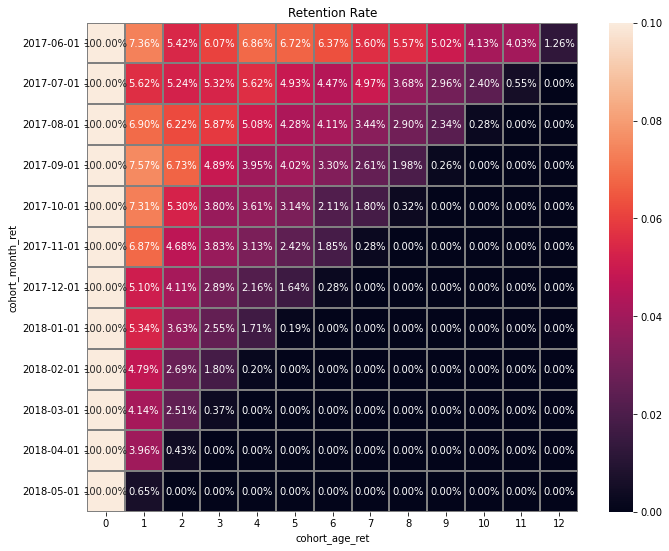

In [37]:
plt.figure(figsize = (11, 9))
sns.heatmap(retention, annot = True, fmt = '.2%', linewidths = 1, linecolor = 'grey', vmax = 0.1).set_title('Retention Rate')
plt.show()

We can see **June, September and October 2017** cohorts have the biggest retention rates at the age of 1-st month lifetime, **September and August 2017** is a leader of the 2-nd month, **June 2017** cohort increases and leads the 3-d age month and remains the leading one since than.

In [38]:
visits.groupby(['uid'], as_index=False)['session_date'].min()

,uid,session_date
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30
...,...,...
228164,18446403737806311543,2017-11-30
228165,18446424184725333426,2017-12-06
228166,18446556406699109058,2018-01-01
228167,18446621818809592527,2017-12-27


In [39]:
first_visit

,uid,first_session_date
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30
...,...,...
228164,18446403737806311543,2017-11-30
228165,18446424184725333426,2017-12-06
228166,18446556406699109058,2018-01-01
228167,18446621818809592527,2017-12-27


### Intermediate conclusion

We analyzed our product from different perspectives of users' activity metrics, such as DAU/WAU/MAU, session per day, sessions per user, ASL and retention rate. 
* We saw a period of very high, above average activity in the period from the end of September 2017 until end of March 2018. 
* On average every month we had ~24000 active users, every user is 1.08 session
* The most frequent session length lasts 60 seconds, on average the session lasts roughly ~300 seconds
* The retention rate is the highest for June, September and October 2017 cohorts (~7.5% retention rate) on their first month, September and August 2017 take lead on the second month with ~6.5% retention rate and June 2017 cohort takes lead on the third month with 6.07% rate and stays the highest one since then.

## *Lets' learn what our sales were like*


---




**When do people start buying?** 

In KPI analysis, we're usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. For example, if registration and the first purchase occur on the same day, the user might fall into category Conversion 0d. If the first purchase happens the next day, it will be Conversion 1d. 


In [40]:
# Find the date of the first purchase for every user id
first_purchase = orders.groupby(['uid'], as_index=False)['buy_ts'].min()
first_purchase.columns = ['uid', 'first_purchase']
first_purchase.head()

,uid,first_purchase
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [41]:
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,asl_sec,first_session_date,cohort_month_ret,cohort_age_ret
319105,touch,2017-12-11 22:02:00,3,2017-12-11 21:55:00,3309283011200855838,2017-12-01,2017-12-07,2017-12-11,420,2017-12-11,2017-12-01,0


In [42]:
# Merge the first purchases to the main table
visits = visits.merge(first_purchase, on = ['uid'])

In [43]:
# Calculate the conversion
visits['days_conversion'] = ((pd.to_datetime(visits['first_purchase']) - pd.to_datetime(visits['first_session_date'])) / np.timedelta64(1,'D')).astype('int')

In [44]:
visits['days_conversion'].median()

1.0

In [45]:
visits['days_conversion'].value_counts()

0      44417
1       6394
2       2476
4       2389
3       1621
       ...  
312        2
288        2
358        2
329        1
335        1
Name: days_conversion, Length: 349, dtype: int64

In [46]:
fig = px.histogram(visits, x='days_conversion', nbins=200)
fig.show()

Conclusion - on average users convert between the 0-th to the 4-th day, most frequently on the 0-th or the 1-st.

**How many orders do they make during a given period of time?**

 We will use the aproach of cohort analysis to see how many purchases per user were made over a given period of time.

In [47]:
#defining cohort month through first purchase
orders = orders.merge(first_purchase, on=['uid'])
orders['first_purchase_month'] = orders['first_purchase'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_purchase,first_purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01


In [48]:
# Add the purchase month column
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_purchase,first_purchase_month,purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [49]:
# Find each cohorts' initial size
cohort_sizes = orders.groupby(['first_purchase_month'], as_index=False).agg({'uid': 'nunique'})
cohort_sizes.columns = ['first_purchase_month','cohort_size']
cohort_sizes.head()

,first_purchase_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [50]:
# Select the cohorts by the month of their first purchase
cohorts = orders.groupby(['first_purchase_month', 'purchase_month'])['buy_ts'].count().reset_index()
cohorts.columns = ['first_purchase_month','purchase_month', 'n_purchases']
cohorts.head()

,first_purchase_month,purchase_month,n_purchases
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [51]:
# Merge the cohorts with the sizes table
cohorts = cohorts.merge(cohort_sizes,on = ['first_purchase_month'])
cohorts

,first_purchase_month,purchase_month,n_purchases,cohort_size
0,2017-06-01,2017-06-01,2354,2023
1,2017-06-01,2017-07-01,177,2023
2,2017-06-01,2017-08-01,174,2023
3,2017-06-01,2017-09-01,226,2023
4,2017-06-01,2017-10-01,292,2023
...,...,...,...,...
74,2018-03-01,2018-05-01,176,3533
75,2018-04-01,2018-04-01,2495,2276
76,2018-04-01,2018-05-01,195,2276
77,2018-05-01,2018-05-01,3249,2988


In [52]:
# Find the cohorts' ages
cohorts['age_month'] = ((cohorts['purchase_month'] - cohorts['first_purchase_month']) / np.timedelta64(1,'M')).round().astype('int')

In [53]:
# Calculate a purchase per buyer metric
cohorts['purchases_per_buyer'] = cohorts['n_purchases'] / cohorts['cohort_size']
cohorts.head()

,first_purchase_month,purchase_month,n_purchases,cohort_size,age_month,purchases_per_buyer
0,2017-06-01,2017-06-01,2354,2023,0,1.163618
1,2017-06-01,2017-07-01,177,2023,1,0.087494
2,2017-06-01,2017-08-01,174,2023,2,0.086011
3,2017-06-01,2017-09-01,226,2023,3,0.111715
4,2017-06-01,2017-10-01,292,2023,4,0.144340


In [54]:
# Create a pivot table with a cumulative sum method. It will allow us to see how purchases cumulate over time
cohorts_pivot = cohorts.pivot_table(
    index='first_purchase_month', 
    columns='age_month', 
    values='purchases_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

cohorts_pivot.round(2).fillna(0)

age_month,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.70,1.84,1.92,2.03,2.10,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,0.00
2017-08-01,1.12,1.20,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.60,0.00,0.00
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.50,0.00,0.00,0.00
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,0.00,0.00,0.00,0.00
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,0.00,0.00,0.00,0.00,0.00
2017-12-01,1.15,1.21,1.26,1.30,1.32,1.34,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,1.12,1.19,1.24,1.25,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,1.12,1.18,1.21,1.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [55]:
cohorts_pivot.index = cohorts_pivot.index.astype('str')

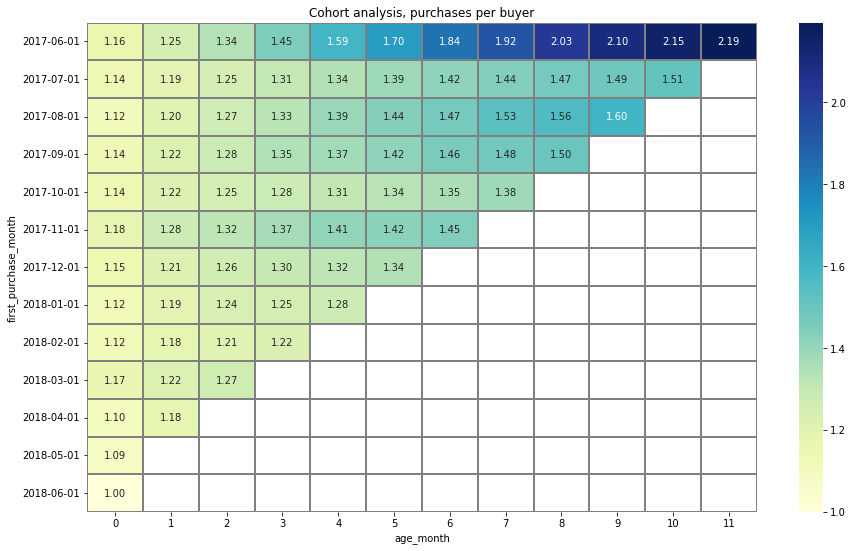

In [56]:
plt.figure(figsize = (15, 9))
sns.heatmap(cohorts_pivot, annot = True, fmt = '.2f', linewidths = 1, cmap = 'YlGnBu', linecolor = 'grey').set_title('Cohort analysis, purchases per buyer')
plt.show()

In [57]:
print('On average a user makes {:.2f} purchases.'.format(cohorts_pivot[5].mean()))

On average a user makes 1.43 purchases.


We can see that the **June 2017** and **November 2017** cohorts started off with the highest amount of purchases per buyer. They tend to have the highest values alongside with the **August 2017** and **September 2017** cohorts, but the overall picture doesn't change much and all of the metrics seem to encrease more or less evenly.

**What is the average purchase size?**

A cohort analysis is good for this situation as well - we just need to calculate the average check and visualize how it spreaded in a cutaway of different cohorts throughout the given period of time.

In [58]:
avg_purchase = orders.groupby(['buy_ts'], as_index=False)['revenue'].sum()
avg_purchase.head()

,buy_ts,revenue
0,2017-06-01 00:10:00,17.00
1,2017-06-01 00:25:00,0.55
2,2017-06-01 00:27:00,0.37
3,2017-06-01 00:29:00,0.55
4,2017-06-01 07:58:00,0.37


In [59]:
print('The overall average check is {}'.format(avg_purchase['revenue'].median()))

The overall average check is 2.82


In [60]:
fig = px.histogram(avg_purchase, x='revenue')
fig.show()

In [61]:
avg_purchase['revenue'].describe()


count    45991.000000
mean         5.480577
std         22.922826
min          0.000000
25%          1.400000
50%          2.820000
75%          5.500000
max       2633.280000
Name: revenue, dtype: float64

We can see that a lot of our observations are concentrated near the 0, there certainly are some big values as well, according to the gap between the 75-th percintile and the maximum value. The distribution is very skewd to the left, so as with average sesion length this question demends more exploring.

In [62]:
orders.head()

,buy_ts,revenue,uid,first_purchase,first_purchase_month,purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [63]:
# Make cohorts according to the first purchase month
avg_cohort = orders.groupby(['first_purchase_month', 'purchase_month'], as_index=False)['revenue'].mean()
avg_cohort['age_month'] = ((avg_cohort['purchase_month'] - avg_cohort['first_purchase_month']) / np.timedelta64(1, 'M')).round().astype('int')
avg_cohort

,first_purchase_month,purchase_month,revenue,age_month
0,2017-06-01,2017-06-01,4.060106,0
1,2017-06-01,2017-07-01,5.547006,1
2,2017-06-01,2017-08-01,5.088161,2
3,2017-06-01,2017-09-01,8.545575,3
4,2017-06-01,2017-10-01,7.084178,4
...,...,...,...,...
74,2018-03-01,2018-05-01,6.334489,2
75,2018-04-01,2018-04-01,4.248774,0
76,2018-04-01,2018-05-01,6.204718,1
77,2018-05-01,2018-05-01,4.286168,0


In [64]:
# Create a pivot table for average check
avg_cohort_pivot = avg_cohort.pivot_table(
    index='first_purchase_month', 
    columns='age_month', 
    values='revenue', 
    aggfunc='median'
)

avg_cohort_pivot.round(2).fillna(0)

age_month,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,0.00
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.70,5.60,0.00,0.00
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,0.00,0.00,0.00
2017-10-01,4.37,7.41,5.13,5.59,5.10,5.07,4.28,4.01,0.00,0.00,0.00,0.00
2017-11-01,4.37,4.10,4.47,6.28,4.44,3.73,4.60,0.00,0.00,0.00,0.00,0.00
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,3.69,4.44,6.45,7.52,2.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,3.71,4.58,3.45,3.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [65]:
avg_cohort_pivot.index = avg_cohort_pivot.index.astype('str')

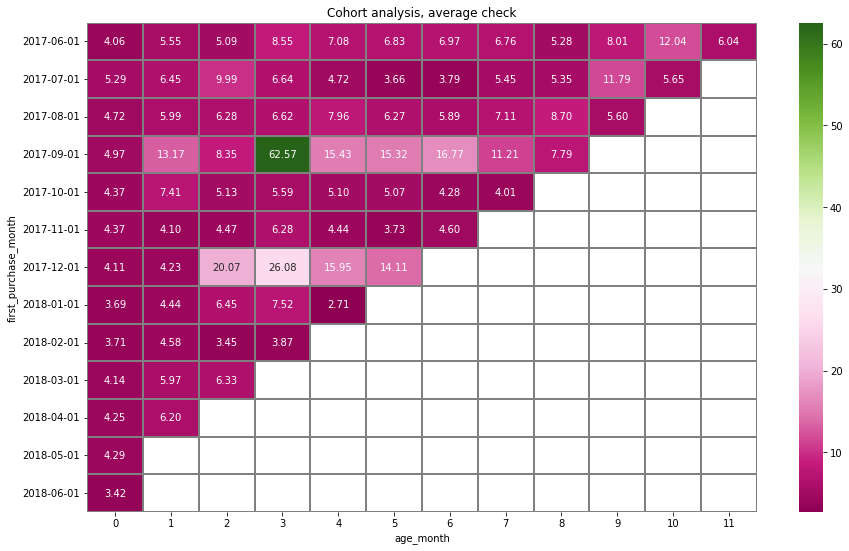

In [66]:
plt.figure(figsize = (15, 9))
sns.heatmap(avg_cohort_pivot, annot = True, fmt = '.2f', linewidths = 1, cmap = 'PiYG', linecolor = 'grey').set_title('Cohort analysis, average check')
plt.show()

In [67]:
print('The total average check is {:.2f}'.format(avg_cohort['revenue'].median()))

The total average check is 5.65


- **September 2017** - the average check is the biggest one for this cohort, especially on their third month of age, which falls on December and New Years' hollidays.
- **December 2017** has pretty high values starting from it's 2-nd month of age in comparison to all of the rest cohorts.

Overall the average check is distributed evenly through time at all other cohorts, there are no visible abrupt peaks.

**How much money do they bring?**

We have a metric to answer this question - LTV or Lifetime Value. 

In [68]:
orders

,buy_ts,revenue,uid,first_purchase,first_purchase_month,purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01


In [69]:
# Find the cohorts by their first purchase month and session month
ltv_cohort = orders.groupby(['first_purchase_month','purchase_month'])['revenue'].sum().reset_index()
ltv_cohort.columns = ['first_purchase_month','purchase_month','total_revenue'] # rename columns
ltv_cohort.head()

,first_purchase_month,purchase_month,total_revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [70]:
# Merge with the cohort sizes
ltv_cohort = ltv_cohort.merge(cohort_sizes, on=['first_purchase_month'])

In [71]:
# Find the age for cohorts
ltv_cohort['age'] = ((ltv_cohort['purchase_month'] - ltv_cohort['first_purchase_month']) / np.timedelta64(1,'M')).round()

In [72]:
# Calculate the ltv
ltv_cohort['ltv'] = ltv_cohort['total_revenue'] / ltv_cohort['cohort_size']

In [73]:
ltv_cohort_pivot = ltv_cohort.pivot_table(
    index='first_purchase_month', 
    columns='age', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)

ltv_cohort_pivot.round(2).fillna(0)

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,0.00
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,0.00,0.00
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,0.00,0.00,0.00
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,0.00,0.00,0.00,0.00
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,0.00,0.00,0.00,0.00,0.00
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,4.14,4.43,4.73,4.88,4.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,4.16,4.44,4.51,4.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [74]:
ltv_cohort_pivot.index = ltv_cohort_pivot.index.astype('str')

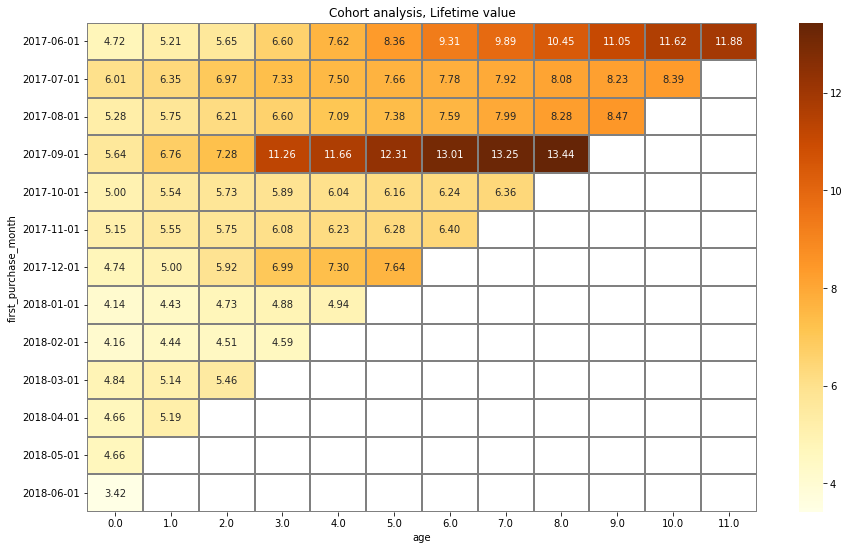

In [75]:
plt.figure(figsize = (15, 9))
sns.heatmap(ltv_cohort_pivot, annot = True, fmt = '.2f', linewidths = 1, cmap = 'YlOrBr', linecolor = 'grey').set_title('Cohort analysis, Lifetime value')
plt.show()

In [76]:
print('The mean LTV is {:.2f}'.format(ltv_cohort_pivot[5].mean()))

The mean LTV is 7.97


Seems like **June 2017, September 2017 and December 2017** have top 3 biggest LTVs and if we recall our DAU graph we can assume that it correlates to the breakpoints of growth and decrease we found there. 

### Intermediate conclusion

We studied our most important sales metrics:
* Conversion - users become depositors between the 0-th to the 4-th day, most frequently on the 0-th or the 1-st.
* Purchases per buyer - this number varies between 3 - 4 purchases at 0-th month. The June 2017 cohort made the largest amount of purchases per buyer with a big gap in comparison with other cohorts.
* Average check - total average check of the period was ~7, cohorts with biggest average check was September 2017.
* Lifetime value - LTV of the June 2017 cohort is times bigger than others, LTV of the Septmber 2017 cohort on 0-th month is biggest.

## *How our marketing expenses were paid off?*


---



**How much money was spent? Overall/per source/over time**

In [77]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [78]:
# Find the total costs
total_costs = costs.groupby(['dt'], as_index = False)['costs'].sum()

In [79]:
print('Total marketing cost is {}'.format(total_costs['costs'].sum()))

Total marketing cost is 329131.62


In [80]:
fig = px.line(total_costs, x='dt', y='costs')
fig.update_layout(yaxis_title='Costs spent', xaxis_title = 'Dates')
fig.show()

This graph looks almost identical to DAU trends.

Lets' see how costs distributed among different sources:

In [81]:
# Calculate the costs for each source id
costs_by_source = costs.groupby(['source_id'])['costs'].sum().reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [82]:
fig = px.bar(costs_by_source, x = 'source_id', y = 'costs', title='Costs by sources', color='source_id')
fig.update_layout(yaxis_title='Costs spent', xaxis_title = 'Sources')
fig.show()

We don't see any costs spent on **6, 7 and 8 source id**. Number **3** was the most expensive source,**2, 4, 5** in the middle and **1**, and especially **9 and 10** are the cheapest ones. Lets' visualize costs over time by differnt sources.

In [83]:
fig = px.line(costs, x="dt", y="costs", color='source_id')
fig.add_hline(y = costs['costs'].median(), line_dash = 'dash', line_color = 'black', annotation_text = 'median costs', annotation_position = 'top left')
fig.update_layout(yaxis_title='Costs spent', xaxis_title = 'Dates')
fig.show()

Basically, we see a repition of the trend in the total costs graph. And same we saw previously on the bar chart - most money spent on source **number 3**; **2, 4, 5** in the middle; **1, 9, 10** - least costs. 

Now we need to calculate the CAC - client aquisition cost. 

**How much did customer acquisition from each of the sources cost?**

Customer acquisition cost (CAC) is the cost related to acquiring a new customer. It is calculated so: `CAC = Sales and Marketing Expenses / Number of Customers`.

In [84]:
# Extract the month from the datetime column
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

In [85]:
# Calculate the expenses for each month
monthly_costs = costs.groupby(['dt_month'], as_index=False)['costs'].sum()
monthly_costs

,dt_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [86]:
# Extract the purchase month from orders table and find the first purchase month for each user
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['firts_purchase_month'] = orders['first_purchase'].astype('datetime64[M]')

In [87]:
orders.head()

,buy_ts,revenue,uid,first_purchase,first_purchase_month,purchase_month,firts_purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01


Now we have the columns we need and we can calculate the amount of depositors in each month.

In [88]:
monthly_depositors = orders.groupby(['firts_purchase_month'], as_index=False)['uid'].nunique()
monthly_depositors.columns = ['dt_month', 'depositors']
monthly_depositors

,dt_month,depositors
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [89]:
# Calculate the CAC
monthly_CAC = monthly_depositors.merge(monthly_costs, on = ['dt_month'])
monthly_CAC

,dt_month,depositors,costs
0,2017-06-01,2023,18015.00
1,2017-07-01,1923,18240.59
2,2017-08-01,1370,14790.54
3,2017-09-01,2581,24368.91
4,2017-10-01,4340,36322.88
5,2017-11-01,4081,37907.88
6,2017-12-01,4383,38315.35
7,2018-01-01,3373,33518.52
8,2018-02-01,3651,32723.03
9,2018-03-01,3533,30415.27


In [90]:
monthly_CAC['CAC'] = monthly_CAC['costs'] / monthly_CAC['depositors']
monthly_CAC

,dt_month,depositors,costs,CAC
0,2017-06-01,2023,18015.00,8.905091
1,2017-07-01,1923,18240.59,9.485486
2,2017-08-01,1370,14790.54,10.796015
3,2017-09-01,2581,24368.91,9.441654
4,2017-10-01,4340,36322.88,8.369327
5,2017-11-01,4081,37907.88,9.288870
6,2017-12-01,4383,38315.35,8.741809
7,2018-01-01,3373,33518.52,9.937302
8,2018-02-01,3651,32723.03,8.962758
9,2018-03-01,3533,30415.27,8.608907


In [91]:
print('Total CAC is {:.2f}'.format(monthly_CAC['CAC'].mean()))

Total CAC is 9.15


In [92]:
fig = px.line(monthly_CAC, x='dt_month', y='CAC', title='Client cost aquisition')
fig.add_hline(y = monthly_CAC['CAC'].mean(), line_dash = 'dash', line_color = 'purple', annotation_text = 'average CAC', annotation_position = 'top left')
fig.update_layout(yaxis_title='CAC', xaxis_title = 'Months')
fig.show()

From what we see the client became most expensive in **August 2017** and since than there are just some more or less equal rising peaks at **November 2017, January and April 2018**. The lower points of CAC are at **October, December 2017 and March 2018**.

Lets' see the how the CAC changes over months in different sources.

In [93]:
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,asl_sec,first_session_date,cohort_month_ret,cohort_age_ret,first_purchase,days_conversion
84302,desktop,2018-05-29 09:31:00,1,2018-05-29 09:29:00,1846459985789541292,2018-05-01,2018-05-24,2018-05-29,120,2018-05-28,2018-05-01,0,2018-05-29 09:30:00,1


In [94]:
visits.groupby(['uid'])['source_id'].nunique()

uid
313578113262317         1
1575281904278712        1
2429014661409475        1
2464366381792757        1
2551852515556206        1
                       ..
18445147675727495770    1
18445407535914413204    2
18445601152732270159    2
18446156210226471712    4
18446167067214817906    1
Name: source_id, Length: 36523, dtype: int64

We can see that users might have more than one source_id, but we are just interested in the one that brought them to Afisha from the very beginning - the initial one.

In [95]:
# Find the first source for each user id
init_source = visits.sort_values('start_ts').groupby('uid').first()['source_id'].reset_index()
init_source.columns = ['uid','init_source']
init_source.head()

,uid,init_source
0,313578113262317,2
1,1575281904278712,10
2,2429014661409475,3
3,2464366381792757,5
4,2551852515556206,5


In [96]:
# Merge our first sources to the main table
visits = visits.merge(init_source, how = 'left', on = ['uid'])
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,asl_sec,first_session_date,cohort_month_ret,cohort_age_ret,first_purchase,days_conversion,init_source
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01,2,2018-03-09 20:25:00,0,4
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09,2018-03-01,0,2018-03-09 20:25:00,0,4
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-01,2017-08-31,2017-09-03,60,2017-09-03,2017-09-01,0,2017-09-04 12:46:00,1,5
3,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-01,2017-10-26,2017-10-27,2520,2017-09-03,2017-09-01,2,2017-09-04 12:46:00,1,5
4,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-01,2017-08-31,2017-09-04,1140,2017-09-03,2017-09-01,0,2017-09-04 12:46:00,1,5


In [97]:
# For each source count the costs it had in every month
monthly_cost_per_source = costs.groupby(['dt_month', 'source_id'], as_index=False)['costs'].sum()
monthly_cost_per_source

,dt_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [98]:
visits['first_purchase_month'] = visits['first_purchase'].astype('datetime64[M]')

In [99]:
# For each source count how many depositors were there in each month
monthly_depositors_per_source = visits.groupby(['first_purchase_month', 'source_id'], as_index=False)['uid'].nunique()
monthly_depositors_per_source.columns =  ['dt_month', 'source_id', 'depositors']
monthly_depositors_per_source

,dt_month,source_id,depositors
0,2017-06-01,1,401
1,2017-06-01,2,457
2,2017-06-01,3,874
3,2017-06-01,4,644
4,2017-06-01,5,571
...,...,...,...
81,2018-05-01,4,987
82,2018-05-01,5,703
83,2018-05-01,9,98
84,2018-05-01,10,164


In [100]:
# Merge those tables to one
monthly_CAC_source = monthly_cost_per_source.merge(monthly_depositors_per_source, how = 'left', on = ['source_id', 'dt_month'])
monthly_CAC_source

,dt_month,source_id,costs,depositors
0,2017-06-01,1,1125.61,401
1,2017-06-01,2,2427.38,457
2,2017-06-01,3,7731.65,874
3,2017-06-01,4,3514.80,644
4,2017-06-01,5,2616.12,571
...,...,...,...,...
79,2018-05-01,3,9411.42,1006
80,2018-05-01,4,4214.21,987
81,2018-05-01,5,3669.56,703
82,2018-05-01,9,362.17,98


In [101]:
# Calculate CAC
monthly_CAC_source['CAC'] = monthly_CAC_source['costs'] / monthly_CAC_source['depositors']

In [102]:
fig = px.line(monthly_CAC_source, x='dt_month', y='CAC', color='source_id', title='Client aquisition cost by Sources')
fig.update_layout(xaxis_title='Months', yaxis_title='Aquisition costs')
fig.show()

We are interested at the bottom of our graph, because this is the position that all of the cheapest sorces are located. Without surprise we see there numbers **1, 9 and 10**. **2, 5, 4** in the middle and **3** the most expensive one.

**How worthwhile where the investments?**

We know this metric by the name of ROI/ROMI - Return of (marketing) investments. In our case it will be the relation of how much money were made (lifetime value) to how much money were spent (client aquisition cost). Good thing we have those already calculated. 

In [103]:
ltv_cohort.head()

,first_purchase_month,purchase_month,total_revenue,cohort_size,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531


From the previously calculated monthly CAC we will take just the month and CAC columns and build from this base a larger table with LTV and finally ROI.

In [104]:
monthly_CAC_ROI = monthly_CAC[['dt_month', 'CAC']]
monthly_CAC_ROI.columns = ['first_purchase_month', 'CAC']
monthly_CAC_ROI.head()

,first_purchase_month,CAC
0,2017-06-01,8.905091
1,2017-07-01,9.485486
2,2017-08-01,10.796015
3,2017-09-01,9.441654
4,2017-10-01,8.369327


In [105]:
# Merge the ltv to cac
ROI = ltv_cohort.merge(monthly_CAC_ROI, on = 'first_purchase_month')
ROI.head()

,first_purchase_month,purchase_month,total_revenue,cohort_size,age,ltv,CAC
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091


In [106]:
# Calculate ROI
ROI['ROI'] = ROI['ltv'] / ROI['CAC']
roi_pivot = ROI.pivot_table(
    index='first_purchase_month', 
    columns='age', 
    values='ROI', 
    aggfunc='mean'
).cumsum(axis=1).round(2) 
ROI.head()

,first_purchase_month,purchase_month,total_revenue,cohort_size,age,ltv,CAC,ROI
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091,0.530530
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091,0.054500
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091,0.049145
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091,0.107205
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091,0.114825


In [107]:
roi_pivot.index = roi_pivot.index.astype(str)

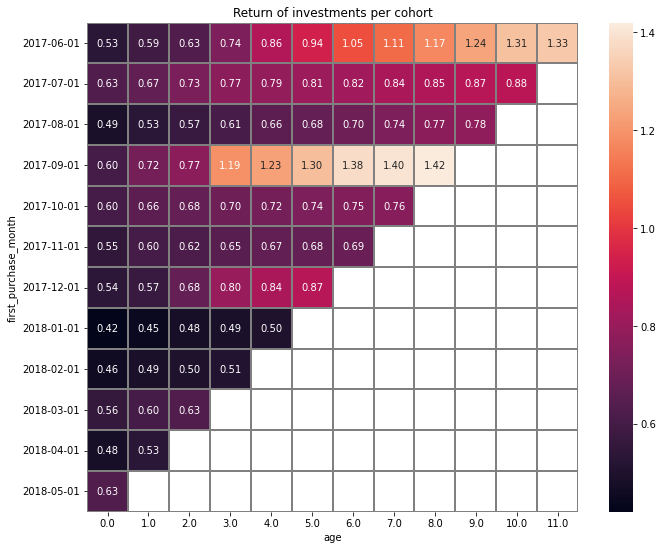

In [108]:
plt.figure(figsize = (11, 9))
sns.heatmap(roi_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='grey').set(title ='Return of investments per cohort')
plt.show()

In [109]:
print('The average overall ROI is {:.0%}'.format(roi_pivot[5].mean()))

The average overall ROI is 86%


We already saw those cohorts leading, here is a similar situation: **June 2017** and **September 2017** return their investments better than other cohorts. But lets' have a look how ROI splited among the sources.

In [110]:
orders = orders.merge(init_source, on='uid')

In [111]:
# Find the amount of depositors and the total revenue for each source id
ltv_per_source = orders.groupby(['init_source'])['uid','revenue'].agg({'uid':'nunique','revenue':'sum'}).reset_index()
ltv_per_source.columns = ['source_id','depositors','revenue']
ltv_per_source.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,source_id,depositors,revenue
0,1,2899,31090.55
1,2,3506,46923.61
2,3,10473,54511.24
3,4,10296,56696.83
4,5,6931,52624.02


In [112]:
# Calculate relevant LTV for each source
ltv_per_source['ltv'] = ltv_per_source['revenue'] / ltv_per_source['depositors']
ltv_per_source.head()

,source_id,depositors,revenue,ltv
0,1,2899,31090.55,10.724577
1,2,3506,46923.61,13.383802
2,3,10473,54511.24,5.204931
3,4,10296,56696.83,5.506685
4,5,6931,52624.02,7.592558


In [113]:
# Merge costs with ltvs together
ROMI_per_source = costs_by_source.merge(ltv_per_source, on=['source_id'])
ROMI_per_source.head()

,source_id,costs,depositors,revenue,ltv
0,1,20833.27,2899,31090.55,10.724577
1,2,42806.04,3506,46923.61,13.383802
2,3,141321.63,10473,54511.24,5.204931
3,4,61073.60,10296,56696.83,5.506685
4,5,51757.10,6931,52624.02,7.592558


In [114]:
# Calculate CAC
ROMI_per_source['cac'] = ROMI_per_source['costs'] / ROMI_per_source['depositors']

In [115]:
# Calculate ROMI
ROMI_per_source['romi'] = ROMI_per_source['ltv'] / ROMI_per_source['cac']
ROMI_per_source.head()

,source_id,costs,depositors,revenue,ltv,cac,romi
0,1,20833.27,2899,31090.55,10.724577,7.186364,1.492351
1,2,42806.04,3506,46923.61,13.383802,12.209367,1.096191
2,3,141321.63,10473,54511.24,5.204931,13.493901,0.385725
3,4,61073.60,10296,56696.83,5.506685,5.931779,0.928336
4,5,51757.10,6931,52624.02,7.592558,7.467479,1.016750


In [116]:
fig = px.bar(ROMI_per_source, x='source_id', y='romi')
fig.update_xaxes(type='category')
fig.show()

In conclusion we can say that among all the sources that showed low cost, **number 1** is definitly the succesfull one, for its' ROMI is the highest one. And on the contrary - wouldn't recommend use the source **number 3** - it turned out the most expensive and the least profitable.

## *Intermediate conclusion*


---


 
Overall spent on marketing 329131.62. Costs over time repeat the trend of DAU/MAU/WAU. We have 7 sources of marketing. The most expensive one was number 3, the cheapest ones were number 1, 9 and 10.
 
 All the sources have their biggest peaks on the 24-th of November 2017

The `CAC` let us see how much money was spent on a user. Biggest expenses took place  in **August 2017** and since than there were just some more or less equal rising peaks at **November 2017, January and April 2018**. The lower points of `CAC` are at **October, December 2017 and March 2018**.

Sources with lowest `CAC` were **1, 9 and 10**. **2, 5, 4** in the middle and **3** the most expensive one.

The `ROI` metric showed us how investments in marketing pays off. Here, 
 **June 2017** and **September 2017** return their investments better than other cohorts. Analysing ROI by the source we found that the cheapets of all sources was **number 1**.

# OVERALL CONCLUSION


---



In our project we had 3 datasets with logs on user activity at Yandex.Afisha. The goal of the analysis was to find and explore all KPI metrics in order to help optimize marketing expenses. 

On the `PREPROCESSING` part we checked the data for missing values, duplicates or inappropriate data types. No issues were found. We fixed the names of the columns and changed date datatypes im visits, orders and costs tables.

On the `PRODUCT` chapter we concluded:
* DAU/WAU/MAU can visualy be devided to three general periods of activity. We saw a period of very high, above average activity in the period from the end of September 2017 until end of March 2018. 
* On average every month we had ~24000 active users, every user made 1.08 sessions.
* The most frequent session length lasts 60 seconds, on average the session lasts roughly ~300 seconds
* The retention rate is the highest for June, September and October 2017 cohorts (~7.5% retention rate) on their first month, September and August 2017 take lead on the second month with ~6.5% retention rate and June 2017 cohort takes lead on the third month with 6.07% rate and stays the highest one since then.


On the `SALES` chapter we found:
* Conversion - users become depositors between the 0-th to the 4-th day, most frequently on the 0-th or the 1-st.
* Purchases per buyer - on average is 1.43  purchases per buyer. The **June 2017** and **November 2017**, **August 2017** and **September 2017** cohorts have the highest tendency of purchases per buyer, but the overall picture doesn't change much and all of the metrics seem to encrease more or less evenly.
* Average check - total average check of the period was ~7, cohorts with biggest average check was September 2017.
* Lifetime value - The average LTV for the first 6 months of the given period is smaller than the average for the second 6 months period which is a good sign of overall growth. The leaders in highest LTV are **June 2017, September 2017 and December 2017**.

On the `MARKETING` chapter:

* Overall spent on marketing 329131.62. 
* Costs over time repeat the trend of DAU/MAU/WAU. 
* Costs by sources analysis showed the most expensive one was number 3, the cheapest ones were number 1, 9 and 10. All the sources have their biggest peaks on the 24-th of November 2017
* The `CAC` metric -  biggest expenses took place  in **August 2017** and since than there were just some more or less equal rising peaks at **November 2017, January and April 2018**. The lower points of `CAC` are at **October, December 2017 and March 2018**.
* Sources with lowest `CAC` were **1, 9 and 10**. **2, 5, 4** in the middle and **3** the most expensive one.
* The `ROI` metric - 
 **June 2017** and **September 2017** return their investments better than other cohorts. 
* Analysing ROI by the source we found that the cheapets of all sources was **number 1**. *It will be the recomended one.*
